In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import numpy as np
import polars as pl

import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc



In [26]:
df = pl.read_excel('UK failures data full.xlsx')
df 

Company name,Registered number,Year of accounts,Failure,OP_S,NI_S,EBITDA_S,OP_TA,NI_TA,EBITDA_TA,ln_CA_CL,WC_TA,WC_S,ln_TA_S,TL_TA,RE_TA,OCF_S,OCF_TA,LTD_TA,TD_TA
str,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""STUK1 LIMITED""","""10475229""",2020,1,-0.366586,-0.309816,-0.355311,-0.769895,-0.810042,-0.716419,-0.468494,-0.502563,-0.175573,0.349355,-1.051667,1.791295,0.995526,0.0,0.0,0.447743
"""HALT (NFR) LIMITED""","""NI677819""",2020,1,-1.841611,-2.202736,-1.703377,-0.769895,-0.810042,-0.716419,-1.206371,-1.575892,-2.912958,1.244142,0.218446,2.524561,2.342445,0.17217,0.138384,0.0
"""CRAZY BEAR GROUP LIMITED""","""10612644""",2020,0,0.156939,0.035576,0.239832,0.085562,0.019396,0.130755,-0.527827,-0.078033,-0.143129,1.834213,0.606616,1.026907,0.150963,0.124558,0.067908,0.728727
"""HUSH BRASSERIES LIMITED""","""03670723""",2020,0,-0.079834,-0.095221,-0.027472,-0.166166,-0.198193,-0.05718,-0.845347,-0.40721,-0.195643,0.480448,-0.733037,1.10778,1.298512,-0.018595,-0.038704,0.394117
"""IOG PLC""","""07434350""",2020,1,-0.080086,-0.377278,0.295693,-0.029245,-0.137768,0.107976,-0.516273,-0.125095,-0.342572,2.738496,1.007409,0.987453,0.329479,0.598477,0.294142,0.478017
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""VISTRY HOMES LIMITED""","""00397634""",2022,0,0.018015,-0.009421,0.020211,0.007531,-0.003938,0.008449,0.283644,0.231755,0.554383,2.392105,0.872174,0.764105,-0.23588,0.0,0.0,0.007821
"""LADBROKES BETTING & GAMING LIM…","""00775667""",2022,0,0.003576,-0.074061,0.150278,0.001074,-0.02224,0.045128,-1.184683,-0.282811,-0.94176,3.330001,1.202973,0.498788,-0.279152,0.0,0.0,0.077278
"""ELLERMAN INVESTMENTS LIMITED""","""01848089""",2022,0,-0.0016,-0.0076,0.0384,-0.000006,-0.000027,0.000135,3.721159,0.997888,7.422585,22.762232,4.915625,0.002007,-0.975112,0.0924,0.000325,0.0


In [27]:
X = df.drop('Company name', 'Registered number', 'Year of accounts', 'Failure')
X.shape

(8210, 16)

In [28]:
y = df['Failure']
y.shape

(8210,)

In [29]:
y.unique()

Failure
i64
0
1


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
# Convert Polars DataFrame/Series to numpy arrays (ensure type is float32 for PyTorch)
X_train_np = X_train.to_numpy().astype(np.float32)
X_test_np  = X_test.to_numpy().astype(np.float32)
y_train_np = y_train.to_numpy().astype(np.float32)
y_test_np  = y_test.to_numpy().astype(np.float32)

# Build Model

In [32]:
# Create PyTorch datasets and dataloaders
train_dataset = TensorDataset(torch.tensor(X_train_np), torch.tensor(y_train_np).unsqueeze(1))
test_dataset  = TensorDataset(torch.tensor(X_test_np), torch.tensor(y_test_np).unsqueeze(1))
train_loader  = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader   = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [33]:
# Define a simple neural network model for binary classification
class Net(nn.Module):
    def __init__(self, input_dim):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_dim, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)  # one output logit for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [34]:
# Initialize the model, loss function and optimizer
input_dim = X_train_np.shape[1]
model = Net(input_dim)
criterion = nn.BCEWithLogitsLoss()  # combines sigmoid with binary cross entropy loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()                # reset gradients
        outputs = model(features)              # forward pass
        loss = criterion(outputs, labels)      # compute loss
        loss.backward()                        # backward pass
        optimizer.step()                       # update weights
        running_loss += loss.item() * features.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 10/100, Loss: 0.2431
Epoch 20/100, Loss: 0.2401
Epoch 30/100, Loss: 0.2377
Epoch 40/100, Loss: 0.2364
Epoch 50/100, Loss: 0.2349
Epoch 60/100, Loss: 0.2336
Epoch 70/100, Loss: 0.2321
Epoch 80/100, Loss: 0.2305
Epoch 90/100, Loss: 0.2287
Epoch 100/100, Loss: 0.2281


In [35]:
# Evaluation on test set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        # Apply sigmoid and classify as 0 or 1
        preds = torch.sigmoid(outputs)
        predicted = (preds > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9245


In [36]:
# Ensure the model is in evaluation mode
model.eval()

Net(
  (fc1): Linear(in_features=16, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=1, bias=True)
)

In [37]:
# Collect all true labels and predicted probabilities from the test set
all_labels = []
all_preds = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        # Convert logits to probabilities using sigmoid
        probs = torch.sigmoid(outputs)
        all_preds.extend(probs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())


In [38]:
# Compute the ROC curve and AUC score
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)


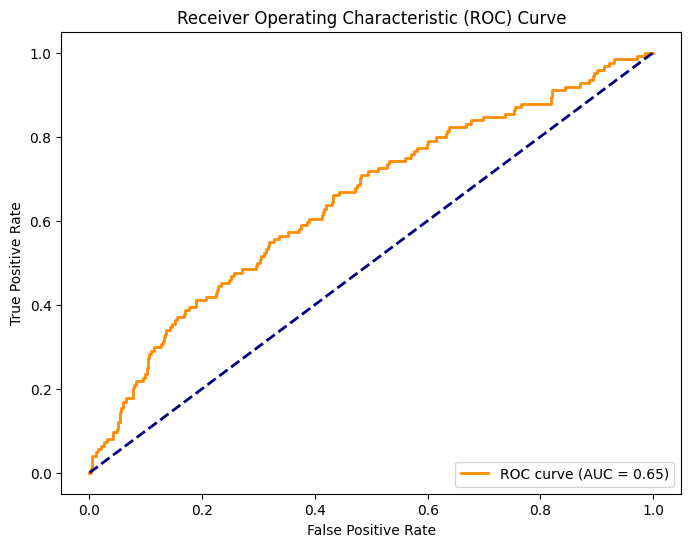

In [39]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [40]:
# Print the amounts (FPR, TPR, and thresholds)
print("False Positive Rates:", fpr)
print("True Positive Rates:", tpr)
print("Thresholds:", thresholds)

False Positive Rates: [0.00000000e+00 6.58761528e-04 2.63504611e-03 2.63504611e-03
 4.61133070e-03 4.61133070e-03 5.27009223e-03 5.27009223e-03
 1.18577075e-02 1.18577075e-02 1.58102767e-02 1.58102767e-02
 2.10803689e-02 2.10803689e-02 2.56916996e-02 2.56916996e-02
 3.03030303e-02 3.03030303e-02 4.21607378e-02 4.21607378e-02
 4.94071146e-02 4.94071146e-02 5.00658762e-02 5.00658762e-02
 5.33596838e-02 5.33596838e-02 5.46772069e-02 5.46772069e-02
 5.59947299e-02 5.59947299e-02 5.86297760e-02 5.86297760e-02
 6.45586298e-02 6.45586298e-02 7.64163373e-02 7.64163373e-02
 7.77338603e-02 7.77338603e-02 7.97101449e-02 7.97101449e-02
 8.30039526e-02 8.30039526e-02 9.48616601e-02 9.48616601e-02
 9.81554677e-02 9.81554677e-02 1.01449275e-01 1.01449275e-01
 1.04084321e-01 1.04084321e-01 1.04743083e-01 1.04743083e-01
 1.06060606e-01 1.06060606e-01 1.10013175e-01 1.10013175e-01
 1.13965744e-01 1.13965744e-01 1.27799736e-01 1.27799736e-01
 1.31093544e-01 1.31093544e-01 1.33069829e-01 1.33069829e-01
 1

# Tuning

In [41]:
class TunedNet(nn.Module):
    def __init__(self, input_dim):
        super(TunedNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.bn1 = nn.BatchNorm1d(64)
        self.dropout1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(64, 32)
        self.bn2 = nn.BatchNorm1d(32)
        self.dropout2 = nn.Dropout(0.3)
        self.fc3 = nn.Linear(32, 16)
        self.dropout3 = nn.Dropout(0.2)
        self.fc4 = nn.Linear(16, 1)  # Output logit

    def forward(self, x):
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.fc3(x))
        x = self.dropout3(x)
        x = self.fc4(x)
        return x

In [42]:
# Instantiate the tuned model
input_dim = X_train_np.shape[1]
model = TunedNet(input_dim)


In [43]:
# Use BCEWithLogitsLoss (which applies sigmoid internally)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)

/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [44]:
# --- Training Loop ---
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * features.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    scheduler.step(epoch_loss)
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 10/150, Loss: 0.2505
Epoch 20/150, Loss: 0.2446
Epoch 30/150, Loss: 0.2437
Epoch 40/150, Loss: 0.2441
Epoch 50/150, Loss: 0.2434
Epoch 60/150, Loss: 0.2416
Epoch 70/150, Loss: 0.2417
Epoch 80/150, Loss: 0.2399
Epoch 90/150, Loss: 0.2403
Epoch 100/150, Loss: 0.2414
Epoch 110/150, Loss: 0.2400
Epoch 120/150, Loss: 0.2410
Epoch 130/150, Loss: 0.2387
Epoch 140/150, Loss: 0.2420
Epoch 150/150, Loss: 0.2442


In [45]:
# --- Evaluate Model and Plot ROC Curve ---
model.eval()
all_labels = []
all_preds = []
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        # Convert logits to probabilities
        probs = torch.sigmoid(outputs)
        all_preds.extend(probs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

In [46]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

AUC: 0.68


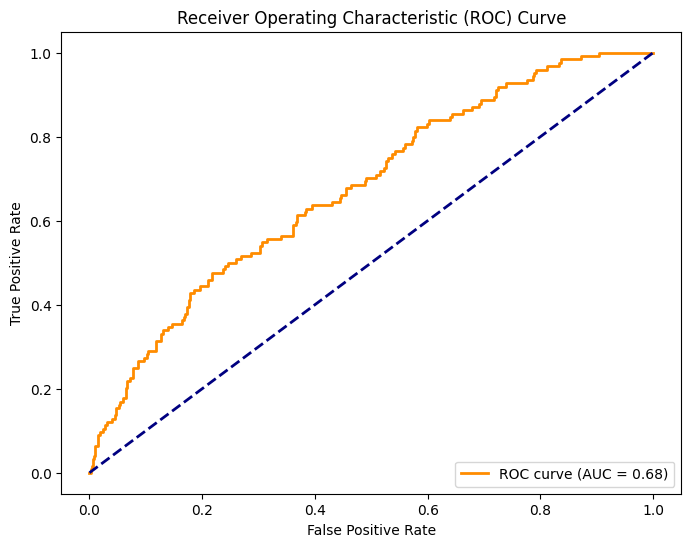

In [47]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [48]:
# Print the ROC amounts
print("False Positive Rates:", fpr)
print("True Positive Rates:", tpr)
print("Thresholds:", thresholds)

False Positive Rates: [0.00000000e+00 6.58761528e-04 3.29380764e-03 3.29380764e-03
 5.27009223e-03 5.27009223e-03 6.58761528e-03 6.58761528e-03
 8.56389987e-03 8.56389987e-03 1.05401845e-02 1.05401845e-02
 1.58102767e-02 1.58102767e-02 1.91040843e-02 1.91040843e-02
 2.37154150e-02 2.37154150e-02 2.83267457e-02 2.83267457e-02
 3.09617918e-02 3.09617918e-02 4.08432148e-02 4.08432148e-02
 4.47957839e-02 4.47957839e-02 4.74308300e-02 4.74308300e-02
 5.20421607e-02 5.20421607e-02 5.33596838e-02 5.33596838e-02
 5.99472991e-02 5.99472991e-02 6.45586298e-02 6.45586298e-02
 6.71936759e-02 6.71936759e-02 7.11462451e-02 7.11462451e-02
 7.70750988e-02 7.70750988e-02 7.77338603e-02 7.77338603e-02
 8.56389987e-02 8.56389987e-02 8.69565217e-02 8.69565217e-02
 9.68379447e-02 9.68379447e-02 1.02108037e-01 1.02108037e-01
 1.04743083e-01 1.04743083e-01 1.18577075e-01 1.18577075e-01
 1.26482213e-01 1.26482213e-01 1.27140975e-01 1.27140975e-01
 1.31093544e-01 1.31093544e-01 1.39657444e-01 1.39657444e-01
 1

# Further tuning of another model, emulating AUC 0.8 model

In [49]:
# --- Define the PyTorch Model (Equivalent to the Keras model) ---
class SimpleNet(nn.Module):
    def __init__(self, input_dim):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, 16)
        self.fc2 = nn.Linear(16, 8)
        self.fc3 = nn.Linear(8, 1)  # Output layer for binary classification

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Apply sigmoid to mimic Keras model output
        return x

In [50]:
# Instantiate the model using the input dimension from your data
input_dim = X_train_np.shape[1]
model = SimpleNet(input_dim)

# Define the loss function and optimizer (matching Keras' binary_crossentropy and adam)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [51]:
# --- Training Loop ---
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for features, labels in train_loader:
        optimizer.zero_grad()                # Clear gradients
        outputs = model(features)              # Forward pass
        loss = criterion(outputs, labels)      # Compute loss
        loss.backward()                        # Backpropagation
        optimizer.step()                       # Update parameters
        running_loss += loss.item() * features.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

Epoch 10/100, Loss: 0.2458
Epoch 20/100, Loss: 0.2413
Epoch 30/100, Loss: 0.2399
Epoch 40/100, Loss: 0.2388
Epoch 50/100, Loss: 0.2374
Epoch 60/100, Loss: 0.2367
Epoch 70/100, Loss: 0.2359
Epoch 80/100, Loss: 0.2345
Epoch 90/100, Loss: 0.2341
Epoch 100/100, Loss: 0.2327


In [52]:
# --- Evaluation ---
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)
        predicted = (outputs > 0.5).float()  # Threshold at 0.5 for binary classification
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 0.9245


In [54]:
model.eval()

all_labels = []
all_probs = []

# Gather predicted probabilities and true labels from the test set
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)  # outputs are probabilities due to sigmoid activation
        all_probs.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

AUC: 0.64


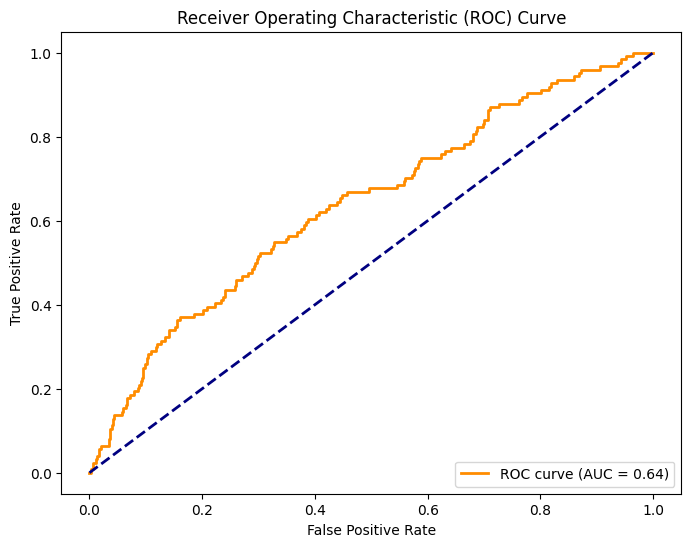

In [55]:
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()


In [56]:
# Optionally, print the ROC amounts
print("False Positive Rates:", fpr)
print("True Positive Rates:", tpr)
print("Thresholds:", thresholds)

False Positive Rates: [0.00000000e+00 6.58761528e-04 2.63504611e-03 2.63504611e-03
 6.58761528e-03 6.58761528e-03 1.18577075e-02 1.18577075e-02
 1.25164690e-02 1.25164690e-02 1.71277997e-02 1.71277997e-02
 1.77865613e-02 1.77865613e-02 1.97628458e-02 1.97628458e-02
 3.42555995e-02 3.42555995e-02 3.49143610e-02 3.49143610e-02
 3.62318841e-02 3.62318841e-02 4.08432148e-02 4.08432148e-02
 4.15019763e-02 4.15019763e-02 4.41370224e-02 4.41370224e-02
 5.79710145e-02 5.79710145e-02 5.92885375e-02 5.92885375e-02
 6.45586298e-02 6.45586298e-02 6.58761528e-02 6.58761528e-02
 6.65349144e-02 6.65349144e-02 7.18050066e-02 7.18050066e-02
 7.83926219e-02 7.83926219e-02 8.62977602e-02 8.62977602e-02
 8.76152833e-02 8.76152833e-02 9.15678524e-02 9.15678524e-02
 9.28853755e-02 9.28853755e-02 9.48616601e-02 9.48616601e-02
 9.55204216e-02 9.55204216e-02 9.88142292e-02 9.88142292e-02
 1.02766798e-01 1.02766798e-01 1.04084321e-01 1.04084321e-01
 1.08695652e-01 1.08695652e-01 1.17918314e-01 1.17918314e-01
 1

# Use 5 Cross fold valuation

AUC: 0.64


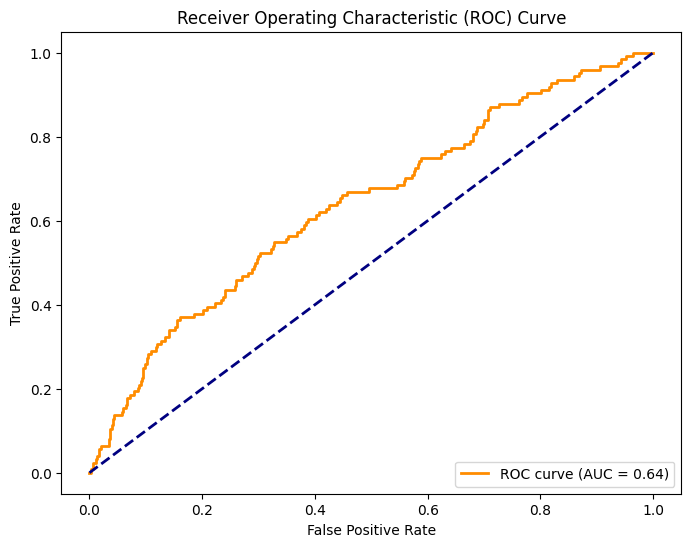

False Positive Rates: [0.00000000e+00 6.58761528e-04 2.63504611e-03 2.63504611e-03
 6.58761528e-03 6.58761528e-03 1.18577075e-02 1.18577075e-02
 1.25164690e-02 1.25164690e-02 1.71277997e-02 1.71277997e-02
 1.77865613e-02 1.77865613e-02 1.97628458e-02 1.97628458e-02
 3.42555995e-02 3.42555995e-02 3.49143610e-02 3.49143610e-02
 3.62318841e-02 3.62318841e-02 4.08432148e-02 4.08432148e-02
 4.15019763e-02 4.15019763e-02 4.41370224e-02 4.41370224e-02
 5.79710145e-02 5.79710145e-02 5.92885375e-02 5.92885375e-02
 6.45586298e-02 6.45586298e-02 6.58761528e-02 6.58761528e-02
 6.65349144e-02 6.65349144e-02 7.18050066e-02 7.18050066e-02
 7.83926219e-02 7.83926219e-02 8.62977602e-02 8.62977602e-02
 8.76152833e-02 8.76152833e-02 9.15678524e-02 9.15678524e-02
 9.28853755e-02 9.28853755e-02 9.48616601e-02 9.48616601e-02
 9.55204216e-02 9.55204216e-02 9.88142292e-02 9.88142292e-02
 1.02766798e-01 1.02766798e-01 1.04084321e-01 1.04084321e-01
 1.08695652e-01 1.08695652e-01 1.17918314e-01 1.17918314e-01
 1

In [57]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
import torch

# Set the model to evaluation mode
model.eval()

all_labels = []
all_probs = []

# Gather predicted probabilities and true labels from the test set
with torch.no_grad():
    for features, labels in test_loader:
        outputs = model(features)  # outputs are probabilities due to sigmoid activation
        all_probs.extend(outputs.cpu().numpy().flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

# Compute the ROC curve and AUC
fpr, tpr, thresholds = roc_curve(all_labels, all_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.2f}")

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Optionally, print the ROC amounts
print("False Positive Rates:", fpr)
print("True Positive Rates:", tpr)
print("Thresholds:", thresholds)
